In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-product-reviews/Reviews.csv


In [2]:
df = pd.read_csv("/kaggle/input/amazon-product-reviews/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [4]:
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df['ProfileName'] = df['ProfileName'].fillna("Unknown")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568454 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [7]:
df = df.dropna(subset=['Summary'])

In [8]:
def label_sentiment(score):
    if score >= 4:
        return "Positive"
    elif score == 3:
        return "Neutral"
    else:
        return "Negative"

df.loc[:, 'Sentiment'] = df['Score'].apply(label_sentiment)
df['Sentiment'].value_counts()

Sentiment
Positive    443777
Negative     82012
Neutral      42638
Name: count, dtype: int64

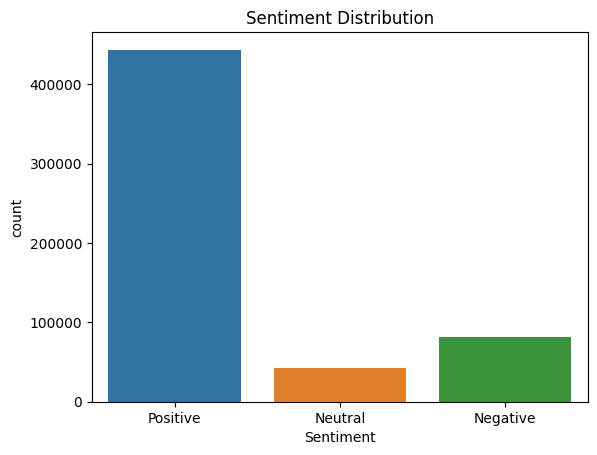

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='Sentiment', order=['Positive', 'Neutral', 'Negative'])
plt.title("Sentiment Distribution")
plt.show()

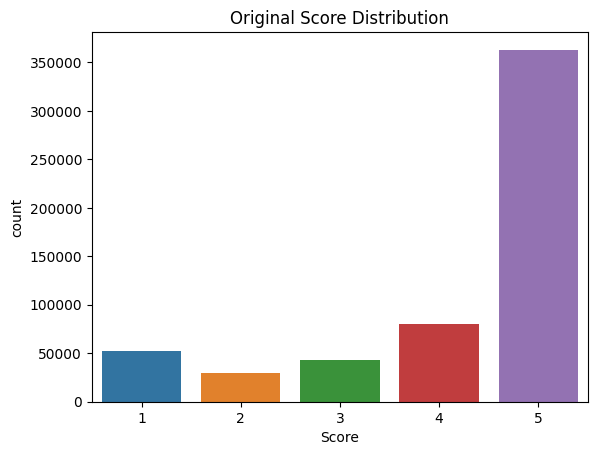

In [10]:
sns.countplot(data=df, x="Score")
plt.title("Original Score Distribution")
plt.show()

In [11]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower().split()
    text = [stemmer.stem(word) for word in text if word not in stop_words]
    return ' '.join(text)

df.loc[:,'CleanText'] = df['Text'].apply(clean_text)
df[['Text', 'CleanText']].head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Text,CleanText
0,I have bought several of the Vitality canned d...,bought sever vital can dog food product found ...
1,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut peanut a...
2,This is a confection that has been around a fe...,confect around centuri light pillowi citru gel...
3,If you are looking for the secret ingredient i...,look secret ingredi robitussin believ found go...
4,Great taffy at a great price. There was a wid...,great taffi great price wide assort yummi taff...


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['CleanText'])
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8636243688756751
              precision    recall  f1-score   support

    Negative       0.73      0.66      0.69     16301
     Neutral       0.50      0.17      0.26      8434
    Positive       0.89      0.97      0.93     88951

    accuracy                           0.86    113686
   macro avg       0.71      0.60      0.63    113686
weighted avg       0.84      0.86      0.85    113686



In [13]:
df.to_csv("amazon.csv", index=False)
